In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

In [65]:
# Input img -> hidden dim -> mean, std -> parametrization
# -> decoder -> output img

class VAE(nn.Module):
    def __init__(self, z_dim=20):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding="same"),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(14*14*64, 32)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1),
            nn.Sigmoid(),
        )

        self.hid2mu = nn.Linear(32, z_dim)
        self.hid2sigma = nn.Linear(32, z_dim)
        self.z2hid = nn.Linear(z_dim, 14*14*64)

    def encode(self, x):
        # q_phi(z|x)
        h = self.encoder(x)
        mu = self.hid2mu(h)
        sigma = self.hid2sigma(h)

        return mu, sigma

    def decode(self, x):
        # p_theta(x|z)
        out = self.decoder(x)
        return torch.sigmoid(out)

    def forward(self, x):
        mu, sigma = self.encode(x)
        # print(mu.shape, sigma.shape)
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon

        z_2d = self.z2hid(z_reparametrized)
        z_2d = z_2d.reshape(z_2d.shape[0], 64, 14, 14)

        x_reconstructed = self.decode(z_2d)

        return x_reconstructed, mu, sigma

In [66]:
r = torch.randn(1000, 3)
r.shape, r.mean(dim=1).mean(), r.std()

(torch.Size([1000, 3]), tensor(0.0242), tensor(1.0203))

In [67]:
x = torch.randn(4, 1, 28, 28)
vae = VAE(z_dim=2)
x_rec, mu, sigma = vae(x)
print(x_rec.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4, 2])
torch.Size([4, 2])


In [68]:
import torchvision.datasets as datasets
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 784
h_dim = 200
z_dim = 2
num_epochs = 30
batch_size = 32
lr_rate = 3e-4

In [72]:
dataset = datasets.MNIST(root="dataset/",
                         train=True,
                         transform=transforms.ToTensor(),
                         download=True)
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True)

model = VAE(z_dim=z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = nn.MSELoss()

In [73]:
for epoch in range(num_epochs):
    for i, (x, y) in tqdm(
        enumerate(train_loader),
        desc=f"Epoch {epoch+1}",
        total=len(train_loader)):
        x = x.to(device)
        x_rec, mu, sigma = model(x)

        # loss
        reconstruction_term = loss_fn(x_rec, x)
        # kl_term = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        kl_term = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        loss = reconstruction_term + kl_term
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Loss: {loss.round().item()} | MSE: {reconstruction_term.round()} | KL: {kl_term.round()}")

Epoch 1: 100%|██████████| 1875/1875 [00:10<00:00, 174.71it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 2: 100%|██████████| 1875/1875 [00:10<00:00, 175.25it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 3: 100%|██████████| 1875/1875 [00:12<00:00, 147.18it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 4: 100%|██████████| 1875/1875 [00:12<00:00, 152.44it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 5: 100%|██████████| 1875/1875 [00:11<00:00, 170.24it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 6: 100%|██████████| 1875/1875 [00:10<00:00, 172.65it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 7: 100%|██████████| 1875/1875 [00:11<00:00, 169.29it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 8: 100%|██████████| 1875/1875 [00:10<00:00, 179.71it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 9: 100%|██████████| 1875/1875 [00:10<00:00, 179.40it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 10: 100%|██████████| 1875/1875 [00:10<00:00, 175.25it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 11: 100%|██████████| 1875/1875 [00:11<00:00, 162.08it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 12: 100%|██████████| 1875/1875 [00:11<00:00, 158.44it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 13: 100%|██████████| 1875/1875 [00:13<00:00, 137.36it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 14: 100%|██████████| 1875/1875 [00:12<00:00, 145.24it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 15: 100%|██████████| 1875/1875 [00:13<00:00, 139.63it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 16: 100%|██████████| 1875/1875 [00:14<00:00, 133.32it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 17: 100%|██████████| 1875/1875 [00:12<00:00, 151.38it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 18: 100%|██████████| 1875/1875 [00:12<00:00, 144.75it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 19: 100%|██████████| 1875/1875 [00:11<00:00, 165.47it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 20: 100%|██████████| 1875/1875 [00:12<00:00, 155.86it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 21: 100%|██████████| 1875/1875 [00:10<00:00, 172.99it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 22: 100%|██████████| 1875/1875 [00:11<00:00, 162.49it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 23: 100%|██████████| 1875/1875 [00:11<00:00, 167.96it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 24: 100%|██████████| 1875/1875 [00:12<00:00, 153.34it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 25: 100%|██████████| 1875/1875 [00:12<00:00, 153.73it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 26: 100%|██████████| 1875/1875 [00:10<00:00, 174.70it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 27: 100%|██████████| 1875/1875 [00:10<00:00, 181.84it/s]


Loss: 0.0 | MSE: 0.0 | KL: -0.0


Epoch 28: 100%|██████████| 1875/1875 [00:11<00:00, 167.01it/s]


Loss: 0.0 | MSE: 0.0 | KL: 0.0


Epoch 29: 100%|██████████| 1875/1875 [00:15<00:00, 124.55it/s]


Loss: 0.0 | MSE: 0.0 | KL: -0.0


Epoch 30: 100%|██████████| 1875/1875 [00:14<00:00, 128.06it/s]

Loss: 0.0 | MSE: 0.0 | KL: 0.0


In [36]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [37]:
x.shape

torch.Size([32, 1, 28, 28])

In [38]:
x = x.view(x.shape[0], 28*28).to(device)
x.shape

torch.Size([32, 784])

In [39]:
x.device

device(type='cuda', index=0)

In [40]:
rec_x, mu, sigma, z = model(x)

In [41]:
rec_x.shape

torch.Size([32, 784])

In [42]:
x2 = rec_x.view(rec_x.shape[0], 28,28).detach().cpu().numpy()
x2.shape

(32, 28, 28)

In [43]:
x1 = x.view(x.shape[0], 28,28).detach().cpu().numpy()
x1.shape

(32, 28, 28)

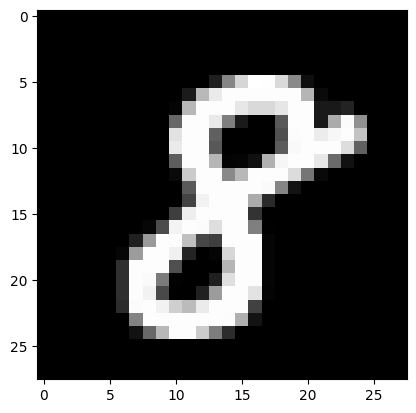

In [44]:
plt.imshow(x1[4], cmap="gray")
plt.show()

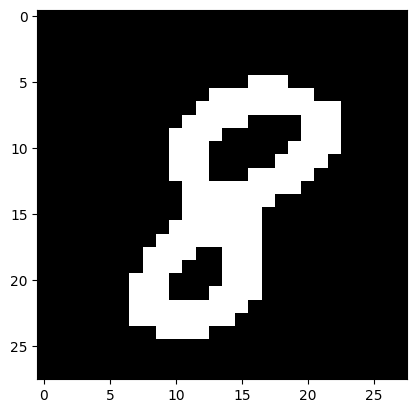

In [46]:
import matplotlib.pyplot as plt
plt.imshow(x2[4].round(), cmap="gray")
plt.show()

In [47]:
z.shape

torch.Size([32, 2])

In [48]:
y.numpy()

array([5, 8, 8, 1, 8, 2, 6, 1, 3, 2, 5, 3, 8, 8, 3, 7, 1, 2, 4, 0, 8, 0,
       8, 2, 3, 8, 9, 4, 0, 0, 9, 6], dtype=int64)

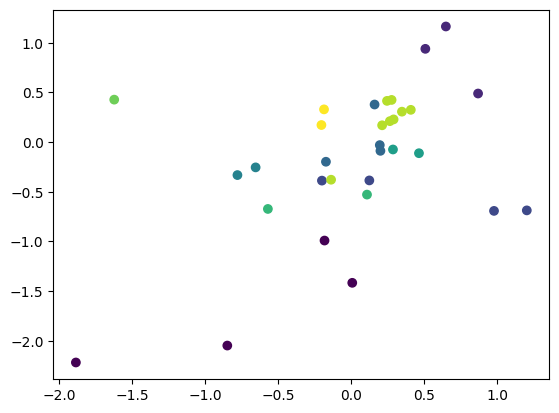

In [49]:
zx = z.detach().cpu()[:, 0]
zy = z.detach().cpu()[:, 1]


plt.scatter(zx, zy, c=y.numpy())